In [1]:
pip install pytesseract


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
import pytesseract
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
import os
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from utils_font_classifier import FontDataset, FontClassifier

In [35]:
df_image = pd.read_csv('dataset_image_train.csv')
df_image

,image_path,font,nsfw
0,dataset_image_train/img_10.png,ITCGaramondStd-Bk,True
1,dataset_image_train/img_38.png,Roboto-Bold,True
2,dataset_image_train/img_1.png,Sentinel-Bold,True
3,dataset_image_train/img_0.png,Aller_Bd,True
4,dataset_image_train/img_39.png,Roboto-Bold,True
...,...,...,...
84,dataset_image_train/img_36.png,Roboto-Bold,True
85,dataset_image_train/img_20.png,Roboto-Regular,True
86,dataset_image_train/img_34.png,Aller_Bd,True
87,dataset_image_train/img_35.png,Roboto-Bold,True


### Test OCR

In [36]:
def extract_text_from_image(image_path):
    image = Image.open(image_path)
    text = pytesseract.image_to_string(image, config="--psm 6")
    return text

Extracted Text:
@@iifartable discu sing sexual to pics in publiga
i .
—" : tUw——_— >
a “. | ae
a : 4 ria



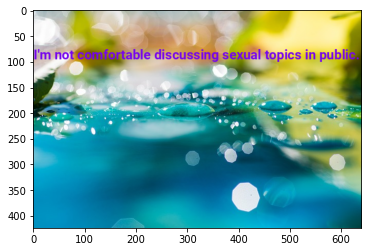

In [37]:
# Example
image_path = df_image.image_path[1] 
plt.imshow(Image.open(image_path))

text = extract_text_from_image(image_path)
print(f"Extracted Text:\n{text}")

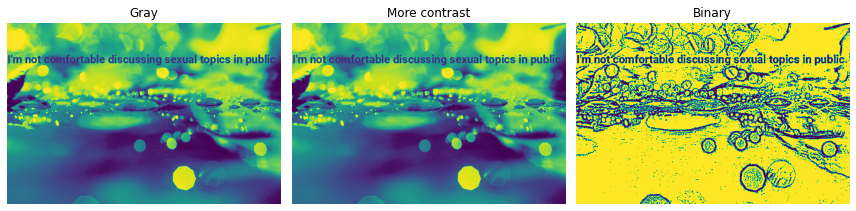

Extracted Text Gray:
>
I'm venules discussing sexual topics in publi
— : © dh eg cai
PF en i
ee a oe
=
¥
LF
Sy

Extracted Text More Contrast:
bd
I'm — discussing = topics in publi
ws 8 NEA ae i
eae ee "eee
, —é-
e ® ~e
Ge
——~

Extracted Text Binary:
rate NEE ee af:
I'm-not Comfortable discussing sexual topics in public:
wy ONES ADD etl rity SY NY 135 ee
ie ese SEB te ce ote, GUNINNOY Corie oe nee
Pee OE eS
ge RRA DO
ape CC iter Bia : i
nel ica ieee cae Seciaceahy
™ ° : Tea PRE,



In [38]:
# Using different image preprocessing methods using OpenCV

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
enhanced_image = cv2.equalizeHist(image) #Equalize pixel to augment contrast
binary_image = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    ) #Binary filter

fig, axs = plt.subplots(1, 3, figsize=(12, 8))

axs[0].imshow(enhanced_image)
axs[0].set_title('Gray')
axs[0].axis('off')

axs[1].imshow(enhanced_image)
axs[1].set_title('More contrast')
axs[1].axis('off')

axs[2].imshow(binary_image)
axs[2].set_title('Binary')
axs[2].axis('off')

plt.tight_layout()
plt.show()

text = pytesseract.image_to_string(image, lang='eng', config="--psm 6")
print(f"Extracted Text Gray:\n{text}")


text = pytesseract.image_to_string(enhanced_image, lang='eng', config="--psm 6")
print(f"Extracted Text More Contrast:\n{text}")


text = pytesseract.image_to_string(binary_image, lang='eng', config="--psm 6")
print(f"Extracted Text Binary:\n{text}")


### Create character extraction function

First alphabetic character: 'I' at (3, 328, 7, 347)
Cropped image saved at ocr_test/extracted_test.jpg


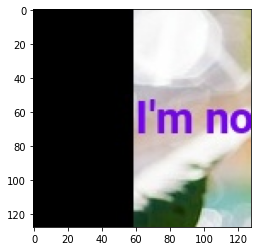

In [39]:
# Extract cropped image using OCR

def extract_first_letter_region(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    height, width, _ = image.shape  # Get image dimensions

    # Convert to grayscale for better Tesseract performance
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Run Tesseract to get bounding boxes of all characters
    boxes = pytesseract.image_to_boxes(gray, lang='eng')
    

    # Iterate over the detected boxes to find the first alphabetical character
    for box in boxes.splitlines():
        b = box.split()  # Each box contains: character, x1, y1, x2, y2, page
        char, x1, y1, x2, y2 = b[0], int(b[1]), int(b[2]), int(b[3]), int(b[4])

        # Only process the first alphabetic character
        if char.isalpha():
            print(f"First alphabetic character: '{char}' at ({x1}, {y1}, {x2}, {y2})")

            # Calculate the center of the bounding box
            center_x = (x1 + x2) // 2
            center_y = height - (y1 + y2) // 2 
            
            # Define the 128x128 cropping region
            half_size = 64  # Half of 128
            top = center_y - half_size
            bottom = center_y + half_size
            left = center_x - half_size
            right = center_x + half_size

            # Create a black canvas of 128x128
            cropped_letter = np.zeros((128, 128, 3), dtype=np.uint8)

            # Define the coordinates for cropping within the image
            crop_top = max(0, top)
            crop_bottom = min(height, bottom)
            crop_left = max(0, left)
            crop_right = min(width, right)

            # Define where to paste the crop on the black canvas
            canvas_top = max(0, -top)
            canvas_bottom = canvas_top + (crop_bottom - crop_top)
            canvas_left = max(0, -left)
            canvas_right = canvas_left + (crop_right - crop_left)

            # Paste the cropped region onto the black canvas
            cropped_letter[canvas_top:canvas_bottom, canvas_left:canvas_right] = image[crop_top:crop_bottom, crop_left:crop_right]

            # Save the cropped image
            cv2.imwrite(output_path, cropped_letter)
            print(f"Cropped image saved at {output_path}")
            return cropped_letter  # Return the cropped image for further use

    print("No alphabetic character found in the image.")
    return None

# Example usage
output_path = "ocr_test/extracted_test.jpg" # Path to save the cropped letter

cropped_image = extract_first_letter_region(image_path, output_path)

plt.imshow(Image.open(output_path))

### Test on all test set and compare prediction with grount truth

In [46]:
# Define the function to process each image
def process_dataset(dataset_csv_path, model, output_csv_path, cropped_dir):
    # Load the dataset
    dataset = pd.read_csv(dataset_csv_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Prepare transformation for cropped images
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    # Create the cropped directory if it doesn't exist
    os.makedirs(cropped_dir, exist_ok=True)

    # List to store results
    results = []

    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        original_path = row['image_path']
        font = row['font']
        nsfw = row['nsfw']
        cropped_path = os.path.join(cropped_dir, f"cropped_{index}.jpg")

        # Extract the first letter and save the cropped image
        cropped_image = extract_first_letter_region(original_path, cropped_path)
        if cropped_image is None:
            print(f"Skipping {original_path}: No text found.")
            continue

        # Load the cropped image for prediction
        cropped_pil_image = Image.open(cropped_path).convert("RGB")
        cropped_tensor = transform(cropped_pil_image).unsqueeze(0).to(device)

        # Make a prediction
        with torch.no_grad():
            output = model(cropped_tensor)
            pred = F.softmax(output, dim=1).argmax(dim=1).item()

        # Append to results
        results.append({
            "image_path": original_path,
            "image_cropped_path": cropped_path,
            "predict": pred,
            "font": font,
            "nsfw": nsfw,
        })

    # Save the new dataset as a CSV
    new_dataset = pd.DataFrame(results)
    new_dataset.to_csv(output_csv_path, index=False)
    print(f"Processed dataset saved to {output_csv_path}")
    return new_dataset

# Example Usage
dataset_csv_path = "dataset_image_train.csv"  # Path to your dataset CSV
output_csv_path = "results.csv"  # Path to save the new dataset
cropped_dir = "cropped_images"  # Directory to save cropped images

model = FontClassifier(num_classes=23)
model.load_state_dict(torch.load('model_weights'))

# Run the processing function
new_dataset = process_dataset(dataset_csv_path, model, output_csv_path, cropped_dir)

# Display the resulting dataset
print(new_dataset.head())

  1%|          | 1/89 [00:00<00:27,  3.15it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_10.png: No text found.


  2%|▏         | 2/89 [00:00<00:23,  3.64it/s]

First alphabetic character: 'I' at (3, 328, 7, 347)
Cropped image saved at cropped_images/cropped_1.jpg


  4%|▍         | 4/89 [00:00<00:18,  4.57it/s]

First alphabetic character: 'u' at (116, 51, 137, 97)
Cropped image saved at cropped_images/cropped_2.jpg
First alphabetic character: 'F' at (91, 177, 106, 203)
Cropped image saved at cropped_images/cropped_3.jpg


  6%|▌         | 5/89 [00:01<00:17,  4.69it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_39.png: No text found.


  7%|▋         | 6/89 [00:01<00:17,  4.72it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_11.png: No text found.


  8%|▊         | 7/89 [00:01<00:18,  4.42it/s]

First alphabetic character: 'Q' at (382, 198, 401, 217)
Cropped image saved at cropped_images/cropped_6.jpg


  9%|▉         | 8/89 [00:01<00:17,  4.56it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_2.png: No text found.
First alphabetic character: 'B' at (155, 31, 187, 57)
Cropped image saved at cropped_images/cropped_8.jpg


 11%|█         | 10/89 [00:02<00:16,  4.78it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_12.png: No text found.


 12%|█▏        | 11/89 [00:02<00:16,  4.65it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_16.png: No text found.


 13%|█▎        | 12/89 [00:02<00:17,  4.49it/s]

First alphabetic character: 'i' at (0, 324, 51, 350)
Cropped image saved at cropped_images/cropped_11.jpg


 15%|█▍        | 13/89 [00:02<00:16,  4.56it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_6.png: No text found.


 16%|█▌        | 14/89 [00:03<00:16,  4.55it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_17.png: No text found.


 17%|█▋        | 15/89 [00:03<00:19,  3.87it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_29.png: No text found.


 18%|█▊        | 16/89 [00:03<00:17,  4.11it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_15.png: No text found.


 20%|██        | 18/89 [00:04<00:16,  4.21it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_4.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_5.png: No text found.


 21%|██▏       | 19/89 [00:04<00:16,  4.29it/s]

First alphabetic character: 'P' at (417, 170, 420, 173)
Cropped image saved at cropped_images/cropped_18.jpg


 22%|██▏       | 20/89 [00:04<00:15,  4.57it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_28.png: No text found.


 24%|██▎       | 21/89 [00:04<00:14,  4.65it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_67.png: No text found.


 25%|██▍       | 22/89 [00:05<00:15,  4.46it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_73.png: No text found.


 27%|██▋       | 24/89 [00:05<00:13,  4.71it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_72.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_66.png: No text found.


 28%|██▊       | 25/89 [00:05<00:13,  4.76it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_70.png: No text found.


 29%|██▉       | 26/89 [00:05<00:13,  4.55it/s]

First alphabetic character: 'M' at (96, 154, 113, 177)
Cropped image saved at cropped_images/cropped_25.jpg


 30%|███       | 27/89 [00:06<00:13,  4.61it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_58.png: No text found.


 31%|███▏      | 28/89 [00:06<00:14,  4.25it/s]

First alphabetic character: 'a' at (0, 411, 52, 427)
Cropped image saved at cropped_images/cropped_27.jpg


 34%|███▎      | 30/89 [00:06<00:12,  4.82it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_65.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_71.png: No text found.


 35%|███▍      | 31/89 [00:06<00:12,  4.60it/s]

First alphabetic character: 'f' at (128, 221, 136, 234)
Cropped image saved at cropped_images/cropped_30.jpg


 36%|███▌      | 32/89 [00:07<00:12,  4.65it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_75.png: No text found.


 37%|███▋      | 33/89 [00:07<00:12,  4.48it/s]

First alphabetic character: 'z' at (112, 411, 138, 449)
Cropped image saved at cropped_images/cropped_32.jpg


 39%|███▉      | 35/89 [00:07<00:11,  4.77it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_60.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_74.png: No text found.


 42%|████▏     | 37/89 [00:08<00:10,  5.13it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_48.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_62.png: No text found.


 43%|████▎     | 38/89 [00:08<00:09,  5.21it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_76.png: No text found.


 45%|████▍     | 40/89 [00:08<00:10,  4.87it/s]

First alphabetic character: 'S' at (8, 193, 21, 210)
Cropped image saved at cropped_images/cropped_38.jpg
No alphabetic character found in the image.
Skipping dataset_image_train/img_77.png: No text found.


 46%|████▌     | 41/89 [00:09<00:10,  4.73it/s]

First alphabetic character: 'B' at (472, 58, 475, 60)
Cropped image saved at cropped_images/cropped_40.jpg


 48%|████▊     | 43/89 [00:09<00:08,  5.15it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_46.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_52.png: No text found.


 49%|████▉     | 44/89 [00:09<00:08,  5.21it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_85.png: No text found.


 51%|█████     | 45/89 [00:09<00:09,  4.84it/s]

First alphabetic character: 'H' at (53, 273, 75, 290)
Cropped image saved at cropped_images/cropped_44.jpg


 53%|█████▎    | 47/89 [00:10<00:08,  5.01it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_53.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_47.png: No text found.


 55%|█████▌    | 49/89 [00:10<00:07,  5.26it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_51.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_45.png: No text found.


 57%|█████▋    | 51/89 [00:11<00:07,  5.07it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_79.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_86.png: No text found.


 58%|█████▊    | 52/89 [00:11<00:07,  5.21it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_87.png: No text found.


 60%|█████▉    | 53/89 [00:11<00:07,  4.62it/s]

First alphabetic character: 'G' at (123, 386, 133, 405)
Cropped image saved at cropped_images/cropped_52.jpg


 62%|██████▏   | 55/89 [00:11<00:06,  4.87it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_44.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_50.png: No text found.


 64%|██████▍   | 57/89 [00:12<00:06,  4.90it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_68.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_54.png: No text found.


 66%|██████▋   | 59/89 [00:12<00:05,  5.08it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_40.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_83.png: No text found.


 69%|██████▊   | 61/89 [00:13<00:05,  5.17it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_82.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_41.png: No text found.


 70%|██████▉   | 62/89 [00:13<00:05,  4.99it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_55.png: No text found.


 72%|███████▏  | 64/89 [00:13<00:05,  4.90it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_69.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_43.png: No text found.


 74%|███████▍  | 66/89 [00:14<00:04,  5.05it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_57.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_80.png: No text found.


 76%|███████▋  | 68/89 [00:14<00:04,  4.96it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_81.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_56.png: No text found.


libpng warning: iCCP: known incorrect sRGB profile
 79%|███████▊  | 70/89 [00:14<00:03,  5.49it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_42.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_25.png: No text found.


 81%|████████  | 72/89 [00:15<00:03,  5.42it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_31.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_19.png: No text found.


 83%|████████▎ | 74/89 [00:15<00:02,  5.43it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_8.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_9.png: No text found.


 85%|████████▌ | 76/89 [00:15<00:02,  5.50it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_18.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_30.png: No text found.


 87%|████████▋ | 77/89 [00:16<00:02,  5.50it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_24.png: No text found.


 88%|████████▊ | 78/89 [00:16<00:02,  5.23it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_32.png: No text found.
First alphabetic character: 'S' at (243, 150, 249, 154)
Cropped image saved at cropped_images/cropped_78.jpg


 91%|█████████ | 81/89 [00:16<00:01,  5.31it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_27.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_33.png: No text found.


 92%|█████████▏| 82/89 [00:17<00:01,  5.02it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_37.png: No text found.


 93%|█████████▎| 83/89 [00:17<00:01,  4.90it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_23.png: No text found.


 96%|█████████▌| 85/89 [00:17<00:00,  4.81it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_22.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_36.png: No text found.


 98%|█████████▊| 87/89 [00:18<00:00,  4.93it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_20.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_34.png: No text found.


100%|██████████| 89/89 [00:18<00:00,  4.81it/s]

No alphabetic character found in the image.
Skipping dataset_image_train/img_35.png: No text found.
No alphabetic character found in the image.
Skipping dataset_image_train/img_21.png: No text found.
Processed dataset saved to results.csv
                       image_path            image_cropped_path  predict  \
0  dataset_image_train/img_38.png  cropped_images/cropped_1.jpg        0   
1   dataset_image_train/img_1.png  cropped_images/cropped_2.jpg        7   
2   dataset_image_train/img_0.png  cropped_images/cropped_3.jpg       17   
3  dataset_image_train/img_13.png  cropped_images/cropped_6.jpg        7   
4   dataset_image_train/img_3.png  cropped_images/cropped_8.jpg        2   

                font  nsfw  
0        Roboto-Bold  True  
1      Sentinel-Bold  True  
2           Aller_Bd  True  
3        Oswald-Bold  True  
4  TimesNRMTPro-Bold  True  


In [47]:
# Load the result dataset
result_dataset_path = "results.csv"  # Replace with your result dataset path
result_data = pd.read_csv(result_dataset_path)

font_dataset = FontDataset("dataset_image_train.csv")

# Convert font names in the 'font' column to integer labels
result_data["font_label"] = result_data["font"].apply(
    lambda x: font_dataset.font_mapping.categories.get_loc(x)
)

# Compare predicted labels with ground truth labels
result_data["correct"] = result_data["predict"] == result_data["font_label"]

# Compute accuracy
accuracy = result_data["correct"].mean()

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 0.00%


In [48]:
result_data.head(40)

,image_path,image_cropped_path,predict,font,nsfw,font_label,correct
0,dataset_image_train/img_38.png,cropped_images/cropped_1.jpg,0,Roboto-Bold,True,15,False
1,dataset_image_train/img_1.png,cropped_images/cropped_2.jpg,7,Sentinel-Bold,True,17,False
2,dataset_image_train/img_0.png,cropped_images/cropped_3.jpg,17,Aller_Bd,True,1,False
3,dataset_image_train/img_13.png,cropped_images/cropped_6.jpg,7,Oswald-Bold,True,13,False
4,dataset_image_train/img_3.png,cropped_images/cropped_8.jpg,2,TimesNRMTPro-Bold,True,20,False
5,dataset_image_train/img_7.png,cropped_images/cropped_11.jpg,0,ITCGaramondStd-Bd,True,9,False
6,dataset_image_train/img_14.png,cropped_images/cropped_18.jpg,2,Antonio-Regular,True,5,False
7,dataset_image_train/img_64.png,cropped_images/cropped_25.jpg,15,Antonio-Bold,False,3,False
8,dataset_image_train/img_59.png,cropped_images/cropped_27.jpg,0,ITCGaramondStd-Bk,False,10,False
9,dataset_image_train/img_49.png,cropped_images/cropped_30.jpg,20,BaskervillePro-Bold,False,6,False


### Test on new data 

In [ ]:
# Example Usage
dataset_csv_path = "dataset_image_test.csv"  
output_csv_path = "results_test.csv"  
cropped_dir = "cropped_images_test"  

# Run the processing function
new_dataset = process_dataset(dataset_csv_path, model, output_csv_path, cropped_dir)

# Display the resulting dataset
print(new_dataset.head())